In [341]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

# Create learning dataset

In [342]:
dataset = pd.read_csv("../data/ready_to_use_datasets/lesfresnes_all.csv")

In [343]:
dataset.rename(columns={"microsensor_pm25_4_C1": "microsensor_pm25"}, inplace=True)
dataset.drop(columns=["microsensor_pm25_3_C1", "microsensor_pm25_5_C1"], inplace=True)

In [344]:
dataset["date"] = pd.to_datetime(dataset["date"])

<Axes: >

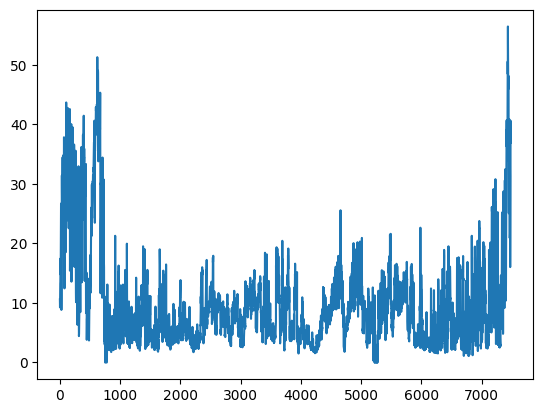

In [345]:
dataset["microsensor_pm25"].plot()

In [346]:
dataset["shift_microsensor_pm25"] = dataset["microsensor_pm25"].shift(1)
# dataset["diff"] = abs(dataset["microsensor_pm25"] - dataset["shift_microsensor_pm25"]) 
dataset["ma_shift_microsensor_pm25"] = dataset["shift_microsensor_pm25"].rolling(12, min_periods=1, closed='left').mean()

In [347]:
dataset

,date,microsensor_pm25,hourofday,monthofyear,season,reference_pm25,temperature,humidity,shift_microsensor_pm25,ma_shift_microsensor_pm25
0,2023-02-06 13:00:00,10.587379,13,2,Winter,10.1,11.29,94.66,NaN,NaN
1,2023-02-06 14:00:00,9.700683,14,2,Winter,8.2,9.56,96.57,10.587379,NaN
2,2023-02-06 15:00:00,9.245219,15,2,Winter,8.2,9.18,97.06,9.700683,10.587379
3,2023-02-06 16:00:00,10.719967,16,2,Winter,9.4,8.60,98.62,9.245219,10.144031
4,2023-02-06 17:00:00,12.139701,17,2,Winter,10.8,7.94,99.81,10.719967,9.844427
...,...,...,...,...,...,...,...,...,...,...
7482,2023-12-30 20:00:00,36.587220,20,12,Winter,31.5,6.41,99.90,32.083224,25.745285
7483,2023-12-30 21:00:00,40.581537,21,12,Winter,37.3,5.55,99.90,36.587220,26.624194
7484,2023-12-30 22:00:00,37.302854,22,12,Winter,33.7,5.02,99.90,40.581537,27.872059
7485,2023-12-30 23:00:00,38.186897,23,12,Winter,34.5,4.38,99.90,37.302854,28.775222


In [348]:
dataset.dropna(inplace=True)

In [349]:
dataset = pd.get_dummies(dataset, columns=["season"])

In [350]:
X = dataset.drop(["reference_pm25", "microsensor_pm25", "date", "monthofyear", "shift_microsensor_pm25"], axis=1)


In [351]:
X

,hourofday,temperature,humidity,ma_shift_microsensor_pm25,season_Autumn,season_Spring,season_Summer,season_Winter
2,15,9.18,97.06,10.587379,False,False,False,True
3,16,8.60,98.62,10.144031,False,False,False,True
4,17,7.94,99.81,9.844427,False,False,False,True
5,18,7.48,99.90,10.063312,False,False,False,True
6,19,7.20,99.90,10.478590,False,False,False,True
...,...,...,...,...,...,...,...,...
7482,20,6.41,99.90,25.745285,False,False,False,True
7483,21,5.55,99.90,26.624194,False,False,False,True
7484,22,5.02,99.90,27.872059,False,False,False,True
7485,23,4.38,99.90,28.775222,False,False,False,True


## Scale data

In [352]:
scaler = MinMaxScaler()
X_cols = X.columns # Store column names
continuous_variables = ["temperature", "humidity"]
X[continuous_variables] = scaler.fit_transform(X[continuous_variables])

## Construct labels

A microsensor measure is labeled wrong if the absolute difference with the reference station exceeds an arbitrarily chosen threshold.

In [353]:
# Construct labels
threshold = 3
y = abs(dataset["reference_pm25"] - dataset["microsensor_pm25"]) < threshold

## Split training and testing sets

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

In [355]:
true_propor = sum(y_train) / len(y_train)
print(f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong.")

83.73% of the training measures are labeled as wrong.


In [356]:
balancer = SMOTE()
X_train, y_train = balancer.fit_resample(X_train, y_train)

In [357]:
true_propor = sum(y_train) / len(y_train)
print(
    f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong after the SMOTE resampling."
)

50.0% of the training measures are labeled as wrong after the SMOTE resampling.


# Single decision tree

## Train the model

In [358]:
decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

## Analyse model

### Metrics

In [359]:
y_pred = decision_tree.predict(X_test)

In [360]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Precision: 0.9435084241823588
Accuracy: 0.6501068376068376
Recall: 0.6141935483870967


<Figure size 800x600 with 0 Axes>

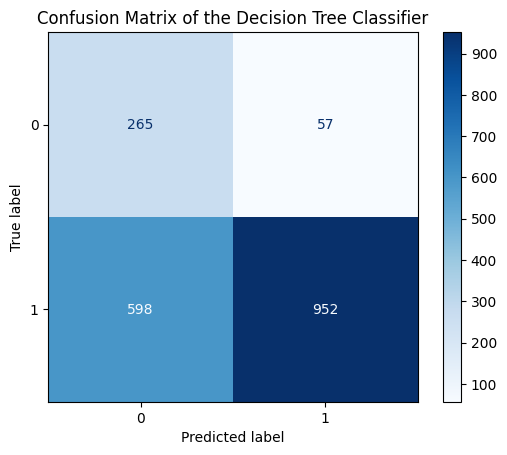

In [361]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if needed

# Set title
plt.title("Confusion Matrix of the Decision Tree Classifier")

# Show the plot
plt.show()


In [362]:
print(f"Proportion of predicted positive: {sum(y_pred) / len(y_pred)}")

Proportion of predicted positive: 0.5389957264957265


### Comparison with dummy classifier

In [363]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_test, y_test)
dummy_pred = dummy_model.predict(X_test)
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Accuracy: {accuracy_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Precision: 0.8285101822079314
Accuracy: 0.49946581196581197
Recall: 0.49870967741935485


### Feature importance

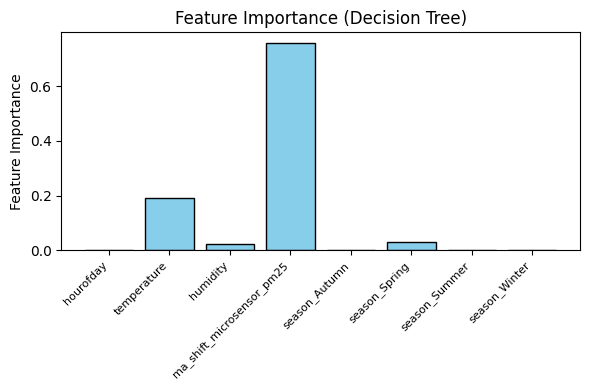

In [364]:
feature_importances = decision_tree.feature_importances_
feature_names = X_cols

plt.figure(figsize=(6, 4))
plt.bar(
    range(len(feature_importances)),
    feature_importances,
    color="skyblue",
    edgecolor="black",
)
plt.xticks(
    range(len(feature_names)), feature_names, rotation=45, ha="right", fontsize=8
)
plt.ylabel("Feature Importance", fontsize=10)
plt.title("Feature Importance (Decision Tree)", fontsize=12)
plt.tight_layout()
plt.show()

### Plot the tree

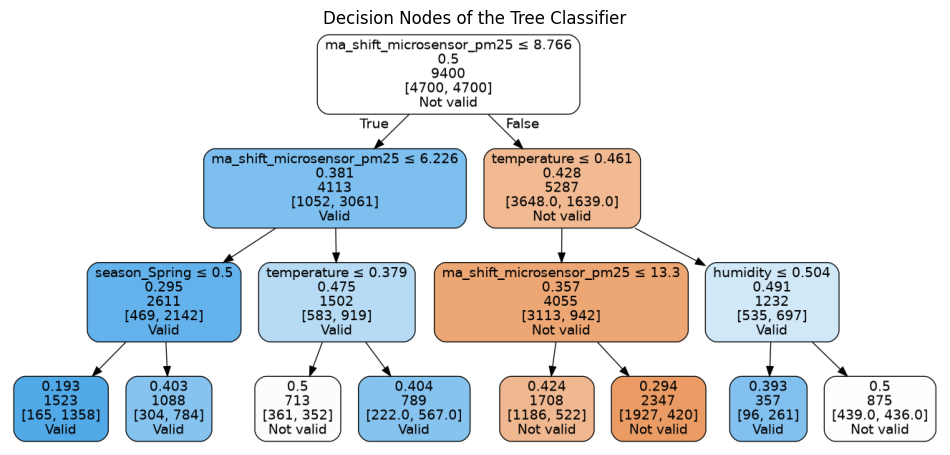

In [365]:
from sklearn.tree import export_graphviz
from graphviz import Source
import matplotlib.pyplot as plt

# Assuming 'decision_tree' is your trained DecisionTreeClassifier model
dot_data = export_graphviz(
    decision_tree, 
    out_file=None, 
    feature_names=X.columns,  # replace with your feature names
    class_names=["Not valid", "Valid"],      # replace with your class names
    filled=True, 
    rounded=True, 
    special_characters=True,
    label='none'
    
)

# Create and render the decision tree using Graphviz
graph = Source(dot_data)
graph.render("fancy_decision_tree", format="png", cleanup=False)

# Display the image
img = plt.imread("fancy_decision_tree.png")
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Decision Nodes of the Tree Classifier")
plt.show()


# XGBoost

## Train the model

### Grid search

In [258]:
# Define parameter grid
param_grid = {
    "learning_rate": [0.1],
    "max_depth": [2, 3, 4],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.3],
    "n_estimators": [50, 100],
}

# Initialize the classifier with fixed parameters
clf = xgb.XGBClassifier(
    tree_method="hist", early_stopping_rounds=4, use_label_encoder=False
)

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1
)

grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

In [202]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100}
Best score: 0.8222689851597065


### Final training

In [ ]:
best_params = grid_search.best_params_
best_params["max_depth"] = 3  # Set to 3 for having nice tree plot
optimized_clf = xgb.XGBClassifier(
    tree_method="hist", early_stopping_rounds=4, **best_params
)
optimized_clf.fit(X_train, y_train, eval_set=[(X_train, y_train)])

[0]	validation_0-logloss:0.66364
[1]	validation_0-logloss:0.63941
[2]	validation_0-logloss:0.61880
[3]	validation_0-logloss:0.60170
[4]	validation_0-logloss:0.58682
[5]	validation_0-logloss:0.57444
[6]	validation_0-logloss:0.56358
[7]	validation_0-logloss:0.55380
[8]	validation_0-logloss:0.54558
[9]	validation_0-logloss:0.53817
[10]	validation_0-logloss:0.53205
[11]	validation_0-logloss:0.52647
[12]	validation_0-logloss:0.52086
[13]	validation_0-logloss:0.51595
[14]	validation_0-logloss:0.51184
[15]	validation_0-logloss:0.50800
[16]	validation_0-logloss:0.50447
[17]	validation_0-logloss:0.50119
[18]	validation_0-logloss:0.49770
[19]	validation_0-logloss:0.49432
[20]	validation_0-logloss:0.49092
[21]	validation_0-logloss:0.48882
[22]	validation_0-logloss:0.48620
[23]	validation_0-logloss:0.48416
[24]	validation_0-logloss:0.48238
[25]	validation_0-logloss:0.48043
[26]	validation_0-logloss:0.47836
[27]	validation_0-logloss:0.47700
[28]	validation_0-logloss:0.47545
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=4,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Analyse model

### Metrics

In [204]:
y_pred = optimized_clf.predict(X_test)

In [205]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Precision: 0.9323361823361823
Accuracy: 0.7858929464732366
Recall: 0.797198538367844


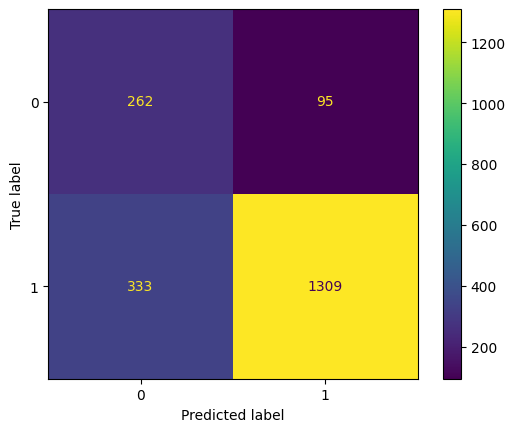

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [207]:
print(f"Proportion of predicted positive: {sum(y_pred) / len(y_pred)}")

Proportion of predicted positive: 0.7023511755877939


### Comparison with dummy classifier

In [ ]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_test, y_test)
dummy_pred = dummy_model.predict(X_test)
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Accuracy: {accuracy_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Precision: 0.8111002921129503
Accuracy: 0.49824912456228115
Recall: 0.5073081607795371


### Feature importance

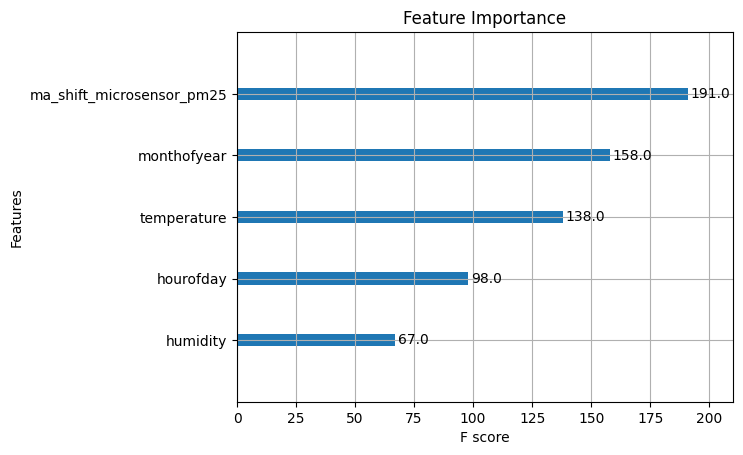

In [ ]:
xgb.plot_importance(optimized_clf, importance_type="weight")
plt.title("Feature Importance")
plt.show()

### Example of a tree

[Tree interpretation guide](https://stats.stackexchange.com/questions/395697/what-is-an-intuitive-interpretation-of-the-leaf-values-in-xgboost-base-learners)

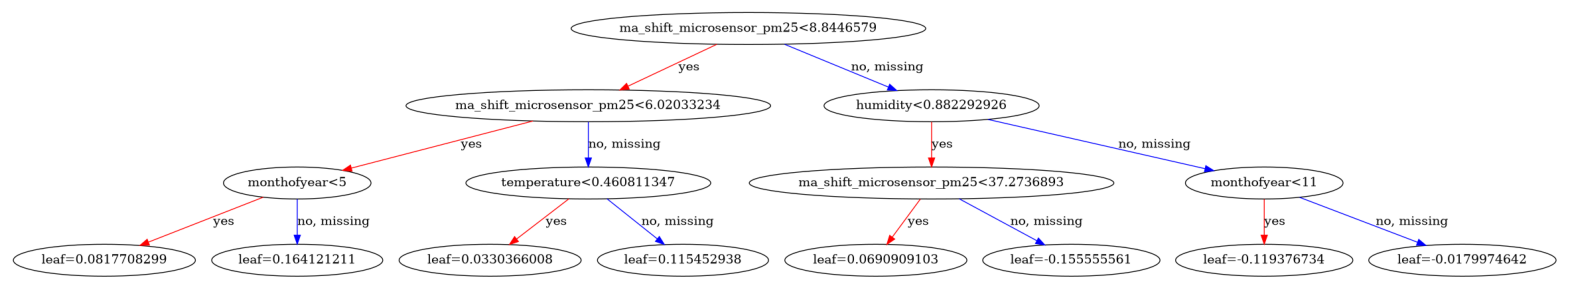

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(optimized_clf, num_trees=0, ax=ax)
plt.show()